In [22]:
import os
import pandas as pd
import joblib
import numpy as np
from collections import Counter


#-----------------------------IMPORTANT-------------------------------------------
### VERY IMPORTANT: Changing the path from library to library2 change the folder of original results
import sys
sys.path.insert(0, '../Script/library3/')

from data_clean_save import *
from utilities import *
from plots import *
import networkx as nx
from tqdm import tqdm
from scipy.special import binom

# Global Inter-event time Distribution

DNC_Mail_part2 0.425091392489
ME 0.297642197375
CollegeMsg 0.0147855757008
EU 0.365067152512


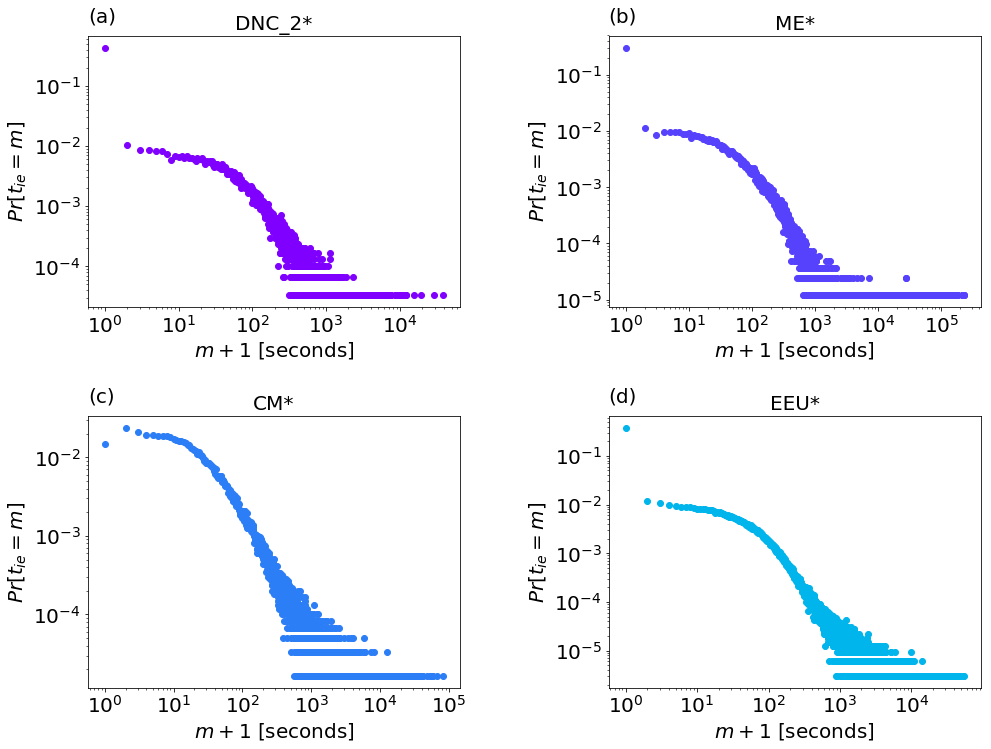

sg_infectious_contact 0.919581430306
primaryschool 0.975367734754
highschool_2012 0.749900102118
highschool_2013 0.960902479006
ht09_contact 0.748186578277
SFHH 0.950085397096
tij_lnVS 0.278037858742
tij_lnVS2 0.763844335101
Hospital 0.708509391481


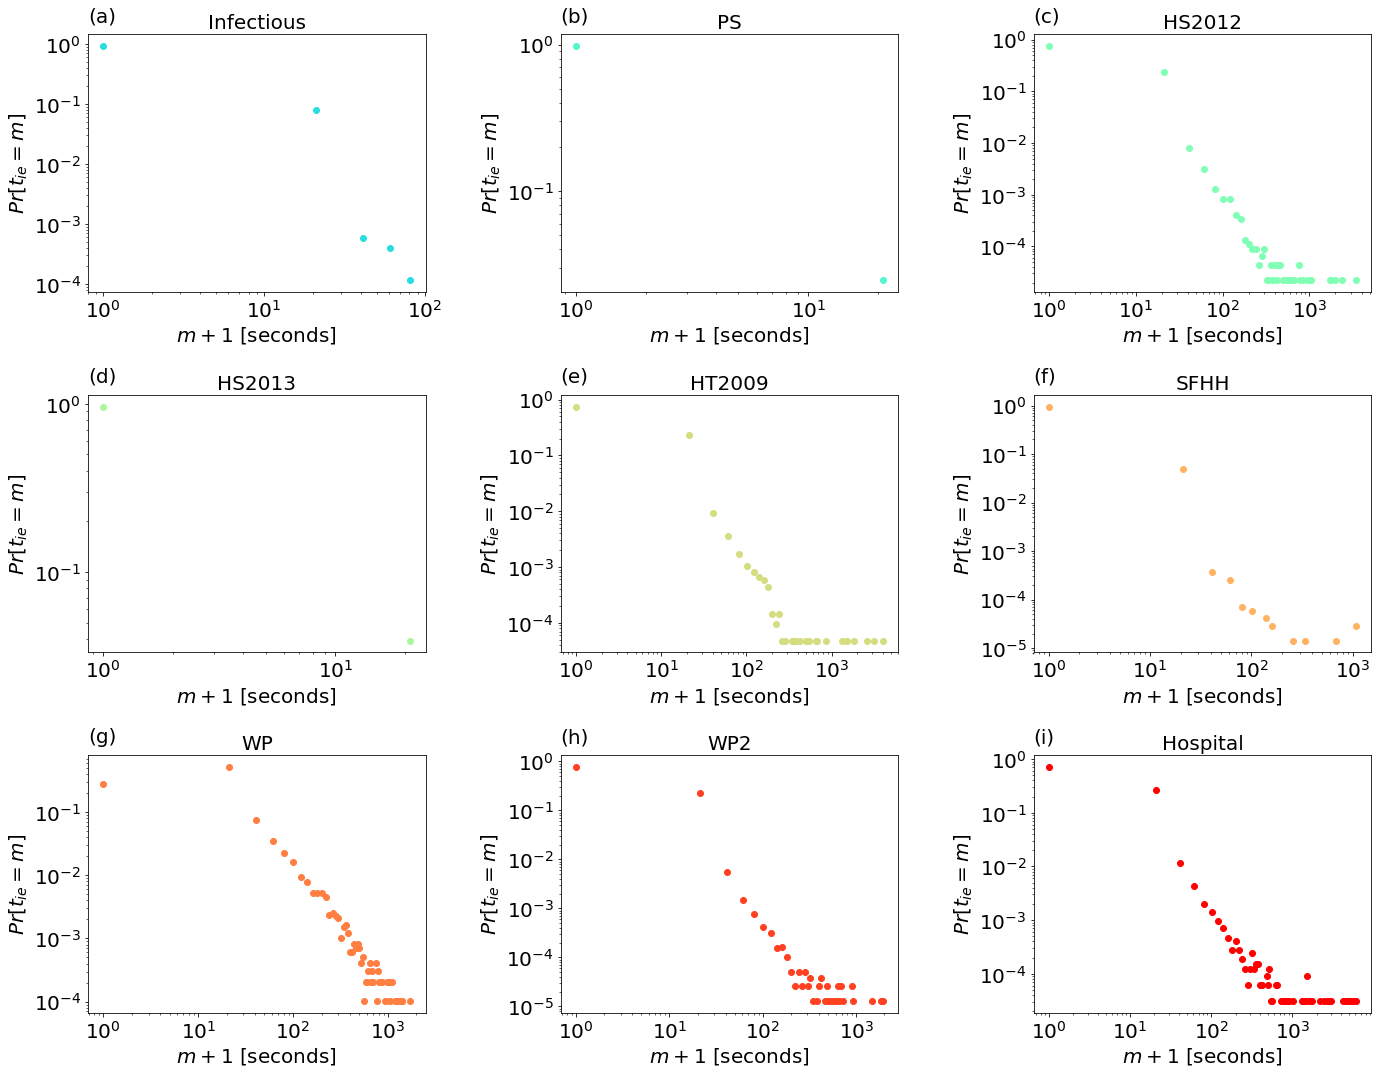

In [5]:
import string
try: os.mkdir('../Results/Plots/Appendix/')
except: 'folder already existing'
i = 0
k1 = 0
for x in [title_list_plot[:4],title_list_plot[4:]]:
    title_list = x
    if len(title_list)>9: fig, ax_list = plt.subplots(ncols=2, nrows=len(title_list_plot)/2,figsize=(12,26))
    elif len(title_list) == 4: fig, ax_list = plt.subplots(ncols=2, nrows= 2,figsize=(16,12))
    elif len(title_list) == 9: fig, ax_list = plt.subplots(ncols=3, nrows= 3,figsize=(23,18))
    fig.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(wspace=0.4)
    
    for plot_index,title1 in enumerate(title_list):
            if title1 in ['mit']:continue
            df = get_df(title1)
            dt = get_dt(df)
            ax_list.flatten()[plot_index].annotate('('+list(string.ascii_lowercase)[plot_index]+')', xy=(0.00, 1.05), xycoords="axes fraction",fontsize = 20,backgroundcolor='1')

            i_et = (df.timestamp.shift(-1)- df.timestamp).iloc[:-1]
            cnt = Counter(i_et)
            print title1,cnt[0]/float(sum(cnt.values()))
            cnt = pd.Series(cnt)
            ax_list.flatten()[plot_index].plot((cnt.index)+1,cnt.values/float(sum(cnt.values)),linestyle = '',marker = 'o',color = color_dic[title1])
            ax_list.flatten()[plot_index].set_xlabel(r'$m+1$ [seconds]',size = 20)
            ax_list.flatten()[plot_index].set_ylabel(r'$Pr[t_{ie} = m]$',size = 20)
            ax_list.flatten()[plot_index].set_title(title_to_paper_name[title1],size = 20)
            i+=1
            ax_list.flatten()[plot_index].tick_params(axis='both', labelsize=20)
            ax_list.flatten()[plot_index].loglog()
            
            

    if len(title_list) == 4: plt.savefig('../Results/Plots/Appendix/mail_global_inter_ev_time.eps',format = 'eps',bbox_inches = 'tight')
    elif len(title_list) == 9: plt.savefig('../Results/Plots/Appendix/physical_global_inter_ev_time.eps',format = 'eps',bbox_inches = 'tight')
    plt.show()
    
    

## Get Topological and temporal Distance

In [29]:
def get_degeneracy(df):
    
    
    
    degenerate_nodes_ts = df.groupby(['timestamp','nodes']).size().sort_values(ascending = False)
    degenerate_nodes_ts = degenerate_nodes_ts.reset_index()
    degenerate_nodes_ts.columns = ['timestamp','nodes','count']
    
    
    deg_timestamp = degenerate_nodes_ts.groupby('timestamp')['count'].apply(lambda x:list(x)).to_dict()
    degenerate_nodes_ts_dic = degenerate_nodes_ts.groupby(degenerate_nodes_ts.nodes)['count'].apply(lambda x:list(x)).to_dict()
    deg_nodes = set(degenerate_nodes_ts.nodes.unique())
    return degenerate_nodes_ts_dic






def diff_iter(a):
    for x in a:
        yield abs(x[0]-x[1])


# In[21]:
def remove_zero_overcount(cnt,deg_nodes):
    for key in [x for x in cnt.keys() if x!=0]:
        cnt[key] = cnt[key]/2.
    
    for x in deg_nodes.values():
        for y in x:
            cnt[0] = cnt[0]-binom(y,2)-y
    return cnt


from collections import Counter
def compute_temporal_distance(list1,nodes_to_time):
    cnt = Counter()
    i = 0
    for x in tqdm(list1):
            date1 = nodes_to_time[x[0]]
            date2 = nodes_to_time[x[1]]
            date_couple = itertools.product(date1, date2)
            cnt.update(Counter(diff_iter(date_couple)))
            i+=1
    
    return cnt





In [46]:

def compute_temp_dist_gvn_top(df,line_graph_distance,title1):




    nodes_to_time = df.groupby('nodes')['timestamp'].apply(lambda x:list(x)).to_dict()

    n = len(nodes_to_time)




    # In[10]:

    #create a Series of line graph distance (hop count)
    sr = pd.Series(index = line_graph_distance.values(),data = line_graph_distance.keys())


    # In[11]:


    del line_graph_distance


    # In[13]:

    #consider just different couples of events (hop count matrix is symmetric!)
    sr = sr.apply(lambda x:frozenset(x) if x[0]!=x[1] else x)


    # In[15]:

    #groupby according to the hop count distance ----> obtain a series of couples of events with hop count k
    sr = sr.groupby(sr.index).apply(lambda x:list(set(x)))


    # In[18]:

    #transform frozenset into tuples to match time event dictionary format
    sr = sr.apply(lambda x:[tuple(y) for y in x])

    #check that the  number of couples in hop count series is exactly the number of independent elements of a symmetric square with n equal to the number of events

    assert sum(sr.apply(lambda x:len(x))) == (n*(n+1))/2.
    # In[19]:






    sr = sr.apply(lambda x: compute_temporal_distance(x,nodes_to_time))
    degenerate_nodes_ts_dic = get_degeneracy(df)
    sr[0] = remove_zero_overcount(sr[0],degenerate_nodes_ts_dic)
    print 'sr saved successfully'

    #joblib.dump(sr,"/tudelft.net/staff-bulk/ewi/insy/MMC/aceria/Temporal_Network/Other_Networks/spatial_to_temporal_analysis/"+title+"_spatial_to_temporal_distr.joblib")
    try: os.mkdir('../Results/avg_temp_dist_gvn_top/')
    except: 'folder already existing'
    #assert (sr == joblib.load("../Results/avg_temp_dist_gvn_top/"+title1+"_spatial_to_temporal_distr.joblib")).all()
    joblib.dump(sr,"../Results/avg_temp_dist_gvn_top/"+title1+"_spatial_to_temporal_distr.joblib")

    T = df.timestamp.shape[0]
    sum1 = 0
    for k in sr.index:
        sum1 +=sum(sr[k].values())
    assert sum1 == (T*(T-1))/2



    mean_var = sr.apply(lambda x:DescrStatsW(x.keys(), weights=x.values())).apply(lambda x: (x.mean,x.std,x.var))

    #joblib.dump(mean_var,"/tudelft.net/staff-bulk/ewi/insy/MMC/aceria/Temporal_Network/Other_Networks/spatial_to_temporal_analysis/"+title+"_spatial_to_temporal_distr_mean_var.joblib")
    #assert (mean_var.apply(lambda x:x[0])==joblib.load('../Results/avg_temp_dist_gvn_top/'+title1+"_spatial_to_temporal_distr_mean_var.joblib").apply(lambda x:x[0])).all()
    joblib.dump(mean_var,'../Results/avg_temp_dist_gvn_top/'+title1+"_spatial_to_temporal_distr_mean_var.joblib")




    gen_cnt = np.sum(sr.values)
    gen_dic = {}
    gen_dic['mean'] = DescrStatsW(gen_cnt.keys(), weights=gen_cnt.values(), ddof=0).mean
    gen_dic['distance_distr'] = sr.apply(lambda x:np.sum(x.values()))
        
    #assert (gen_dic['distance_distr'] == joblib.load("../Results/avg_temp_dist_gvn_top/"+title1+"_spatial_to_temporal_res_cnt.joblib")['distance_distr']).all()
    #assert (gen_dic['mean'] == joblib.load("../Results/avg_temp_dist_gvn_top/"+title1+"_spatial_to_temporal_res_cnt.joblib")['mean'])

    joblib.dump(gen_dic,"../Results/avg_temp_dist_gvn_top/"+title1+"_spatial_to_temporal_res_cnt.joblib")




In [48]:
title1 = 'tij_lnVS'
df = get_df(title1)
# df upload and sort cronologically
df = get_df(title1)
print df.shape
print max(df.timestamp.shift(-1)-df.timestamp)
line_graph_distance = get_distance_line_voc(title1)

compute_temp_dist_gvn_top(df,line_graph_distance,title1)

(9827, 4)
1720.0


100%|██████████| 501/501 [00:00<00:00, 3392.28it/s]


sr saved successfully
0    (90888.92107036582, 91148.22929244558, 8307999...
1    (113898.74387280739, 84885.10791111691, 720548...
2    (121466.75332839908, 86156.13498769513, 742287...
3    (120315.36211742772, 84215.29353512116, 709221...
4    (106429.6804840242, 83771.18695972468, 7017611...
dtype: object 0    (90888.92107036582, 91148.22929244561, 8307999...
1    (113898.74387280739, 84885.10791111691, 720548...
2    (121466.75332839908, 86156.13498769513, 742287...
3    (120315.36211742772, 84215.29353512116, 709221...
4    (106429.6804840242, 83771.18695972468, 7017611...
dtype: object


## Plot Topological and Temporal Distance

In [64]:
def from_cnt_to_iter(cnt):
    for key in cnt.keys():
        for i in range(cnt[key]):
            yield key

def get_time_dist_distr(title1):

    a = joblib.load("../Results/avg_temp_dist_gvn_top/"+title1+'_spatial_to_temporal_distr.joblib')
    cnt = Counter()
    for x in a.iteritems():
        cnt.update(x[1])
    return cnt

def get_top_dist_distr(title1):

    a = joblib.load("../Results/avg_temp_dist_gvn_top/"+title1+'_spatial_to_temporal_res_cnt.joblib')['distance_distr']
    a = pd.Series(a)
    a = a/sum(a)
    return a

### Memory expesive computation of the binned distribution of temporal distance distribution for virtual contact datasets, do this on a cluster preferably

In [ ]:
for title1 in mail_list:
    cnt = get_time_dist_distr(title1)
    bins = from_cnt_to_bin(cnt,50)
    joblib.dump('../Results/avg_temp_dist_gvn_top/binned_distr/binned_hist_dist_'+title1+'.joblib')

### Plot binned temporal distance distribution

In [71]:
def plot_temporal_distance(save=False):
    for x in [mail_list,human_contact_list]:
        title_list = x
        if len(title_list)>9: fig, ax_list = plt.subplots(ncols=2, nrows=len(title_list_plot)/2,figsize=(12,26))
        elif len(title_list) == 4: fig, ax_list = plt.subplots(ncols=2, nrows= 2,figsize=(16,12))
        elif len(title_list) == 9: fig, ax_list = plt.subplots(ncols=3, nrows= 3,figsize=(23,18))
        fig.subplots_adjust(hspace=0.4)
        fig.subplots_adjust(wspace=0.4)

        for plot_index,title1 in enumerate(title_list):
                print title1
                df = get_df(title1)
                max1 = max(df.timestamp)-min(df.timestamp)

                if title1 in human_contact_list:
                    cnt = get_time_dist_distr(title1)
                    bins = from_cnt_to_bin(cnt,50)
                ### for mail dataset the binned plot is preprocessed
                else: bins = joblib.load('../Results/avg_temp_dist_gvn_top/binned_distr/binned_hist_dist_'+title1+'.joblib')


                if title1 in human_contact_list:
                    ax_list.flatten()[plot_index].plot(bins[0],bins[1]/np.sum(bins[1]),marker = 'o',label = title1,color = color_dic[title1])

                else: 
                    ax_list.flatten()[plot_index].plot(bins[0],bins[1]/np.sum(bins[1]),marker = 'o',label = title1,color = color_dic[title1])
                ax_list.flatten()[plot_index].xaxis.offsetText.set_fontsize(15)
                ax_list.flatten()[plot_index].set_title(title_to_paper_name[title1],size = 20)
                ax_list.flatten()[plot_index].set_ylabel(r"$Pr[\mathcal{T}(\ell,\ell') = m]$",size = 20)
                ax_list.flatten()[plot_index].set_xlabel(r"$m$ [seconds]",size = 20)
                ax_list.flatten()[plot_index].tick_params(axis='both', labelsize=20)
                ax_list.flatten()[plot_index].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                ax_list.flatten()[plot_index].annotate('('+list(string.ascii_lowercase)[plot_index]+')', xy=(0.00, 1.05), xycoords="axes fraction",fontsize = 20,backgroundcolor='1')





        if save:
            if len(title_list) == 4:plt.savefig('../Results/Plots/Appendix/mail_dist_distr.eps',format = 'eps',size = 20,bbox_inches = 'tight')

            elif len(title_list) == 9:  plt.savefig('../Results/Plots/Appendix/physical_dist_distr.eps',format = 'eps',size = 20,bbox_inches = 'tight')

        plt.show()

    
    


In [65]:
def plot_top_distance_distr(save = False):
    i = 0
    fig, [ax1,ax2] = plt.subplots(ncols=2, nrows= 1,figsize=(16,6))
    fig.subplots_adjust(wspace = 0.28,bottom = 0.18,hspace = 0.25)

    for k,set1 in enumerate(['mail','human']): 
        if set1 == 'human': 
            list1 = mail_list
            axs = ax2
            marker = 'o'
        if set1 == 'mail': 
            list1 = human_contact_list
            axs = ax1
            marker ='^'
        if set1 in title_list_plot:list1 = [set1]   
        for title1 in list1:
            if title1 in ['mit','DNC_Mail','DNC_Mail_part1']:continue
            print title1
            dict2 = get_top_dist_distr(title1)
            axs.plot(dict2,color = color_dic[title1],marker = marker,label = title_to_paper_name[title1])
            i+=1
        axs.legend(prop ={'size':17})     
        #     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs.set_ylabel(r"$Pr[\eta(\ell,\ell') = j]$",size = 25)
        axs.set_xlabel(r'$j$',size = 25)
        axs.set_ylim(-0.05,0.95)
        axs.tick_params(axis='x', labelsize=25)
        axs.tick_params(axis='y', labelsize=25)
    
  

  
    
    
    if save:
        plt.savefig('../Results/Plots/Appendix/'+'fig13.eps',format = 'eps',bbox_inches = 'tight')
    plt.show()

DNC_Mail_part2
ME
CollegeMsg
EU


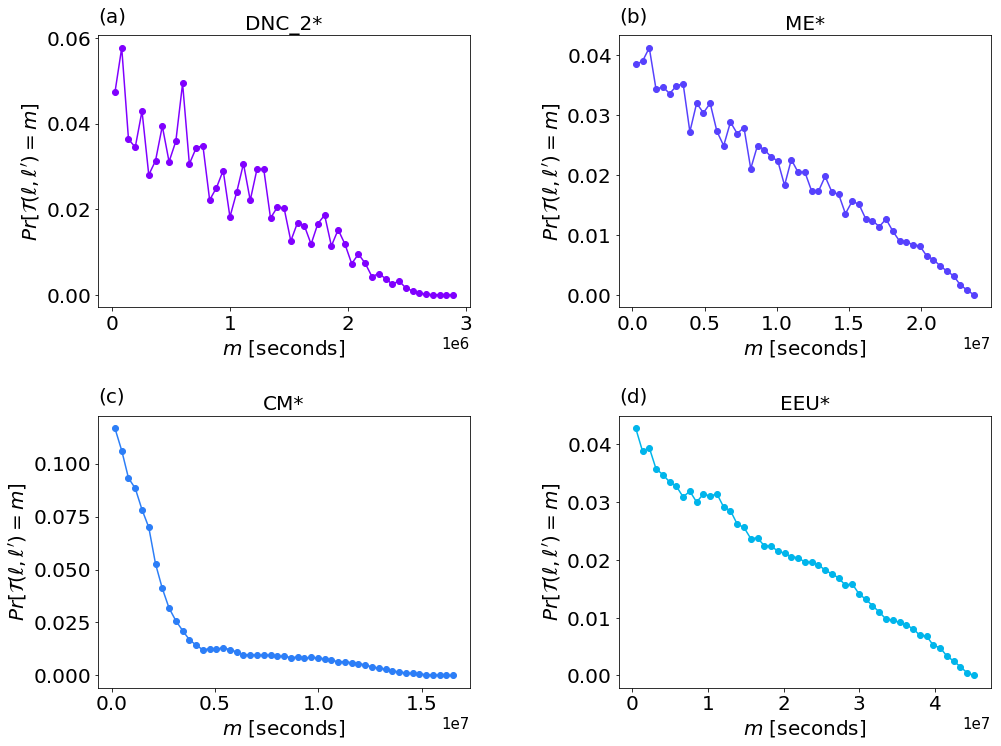

sg_infectious_contact
True
primaryschool
True
highschool_2012
True
highschool_2013
True
ht09_contact
True
SFHH
True
tij_lnVS
True
tij_lnVS2
True
Hospital
True


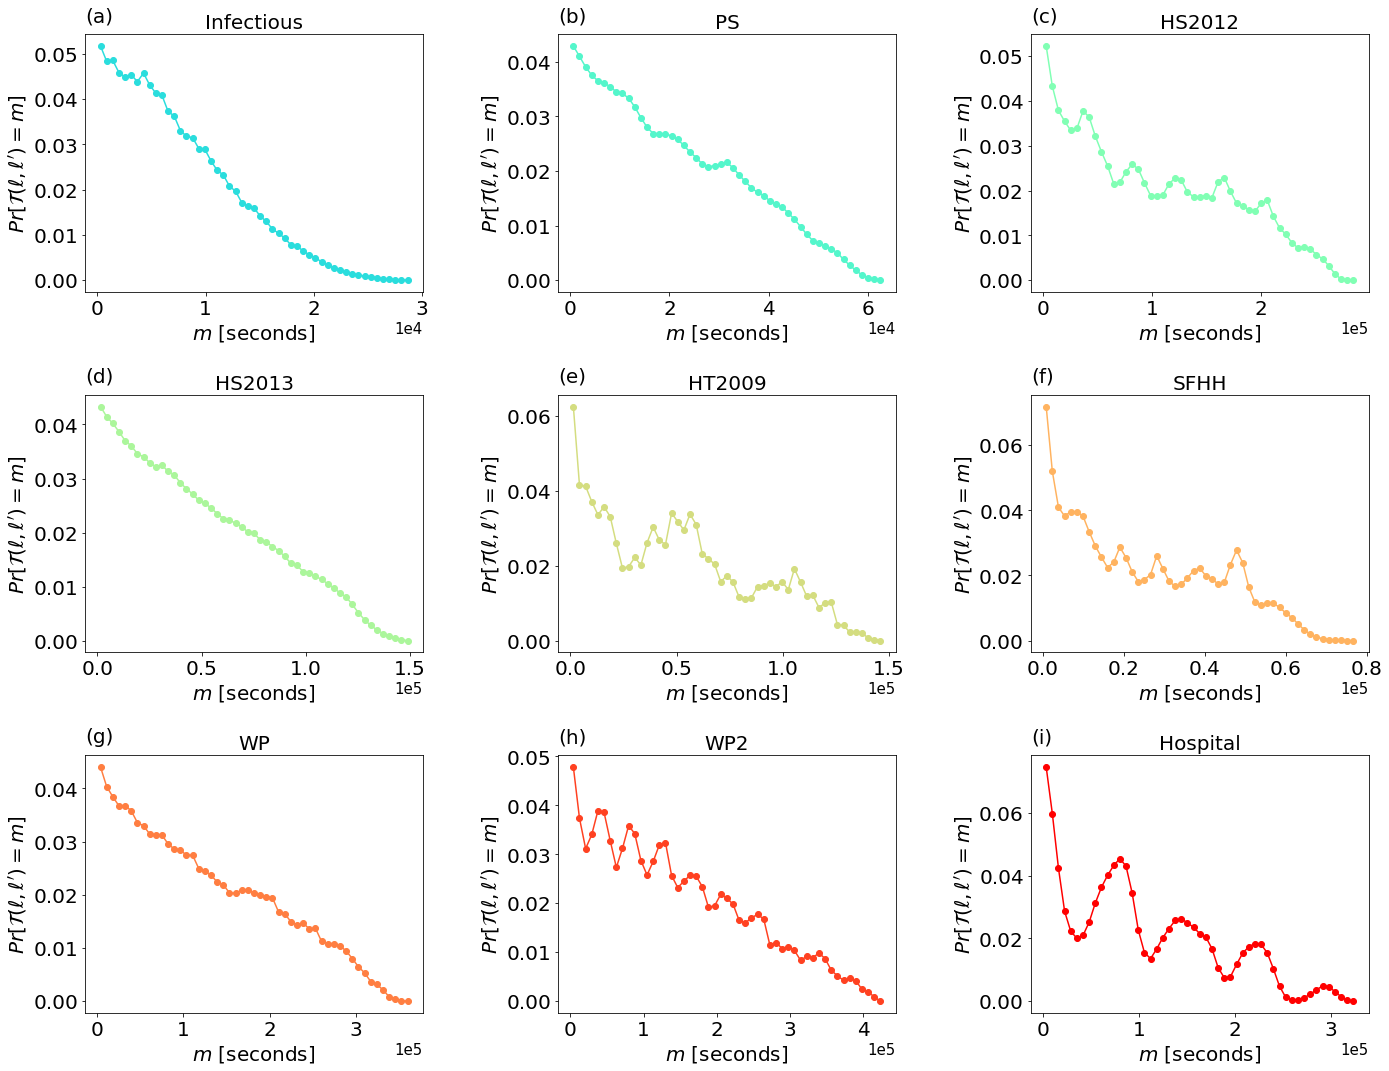

In [73]:
plot_temporal_distance(save=True)

sg_infectious_contact
primaryschool
highschool_2012
highschool_2013
ht09_contact
SFHH
tij_lnVS
tij_lnVS2
Hospital
DNC_Mail_part2
ME
CollegeMsg
EU


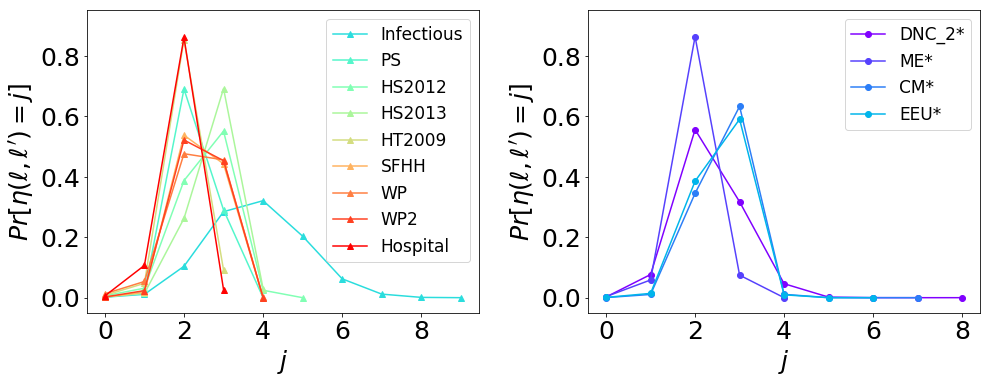

In [67]:
plot_top_distance_distr(save = True)

In [57]:
def binned_sr(sr1,bins):
    sr = sr1.reset_index()
    sr.columns = ['size','count']
    sr['bins'] = pd.cut(sr['size'],bins).apply(lambda x: x.mid)
    sr = sr.groupby('bins')['count'].sum()
    print len(sr)
    return sr


def get_s_link_iet(title1):
    #### always check which library and prepr is considered
    df = get_df(title1)

    a = df.groupby(df.nodes)['timestamp'].apply(lambda x:np.diff(np.array(x))).apply(lambda x: Counter(x))

    cnt = Counter()
    for x in a.values:
        cnt.update(x)
    return cnt

def i_et_distr(title_list, binned = False, save = False):
    
    
    if len(title_list)>9:fig, ax_list = plt.subplots(ncols=2, nrows=len(title_list_plot)/2,figsize=(12,26))
    elif len(title_list) == 4: fig, ax_list = plt.subplots(ncols=2, nrows= 2,figsize=(16,12))
    elif len(title_list) == 9: fig, ax_list = plt.subplots(ncols=3, nrows= 3,figsize=(23,18))
    fig.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(wspace=0.3)

    for plot_index,title1 in enumerate(title_list):
            cnt = get_s_link_iet(title1)
            cnt = pd.Series(cnt)
            cnt1 = cnt.copy()
            if binned:
                range1 = cnt.index.min()-1e-2,cnt.index.max()+1e-2
                bins=np.logspace(np.log10(range1[0]),np.log10(range1[1]),num = 41)
                values1,bins = np.histogram(a=cnt.index,weights=cnt.values,bins = bins)
                cnt = binned_sr(cnt,bins)
                assert sum(cnt) == sum(cnt1)
                
                bins1 = cnt.index
                values1 = cnt.values
                values1 = values1/float(sum(values1))
                values1[values1==0] = np.nan
                values1
                #ax_list.flatten()[plot_index].plot(cnt1.index,cnt1.values/float(sum(cnt1)), marker = 'o')
            ax_list.flatten()[plot_index].plot(bins1,values1, marker = 'o')
            ax_list.flatten()[plot_index].set_title(title_to_paper_name[title1],fontsize = 30)
            ax_list.flatten()[plot_index].set_xscale("log")
            ax_list.flatten()[plot_index].set_yscale("log")
            ax_list.flatten()[plot_index].tick_params(axis='x', labelsize=25)
            ax_list.flatten()[plot_index].tick_params(axis='y', labelsize=25)
            ax_list.flatten()[plot_index].set_ylabel(r'$P[t_{ie} = t]$',size = 30)
            
            ax_list.flatten()[plot_index].set_xlabel(r'$t$',size = 30)
    if save:
        try:os.mkdir('../Results/Plots/')
        except: print 'folder existing'
        try:os.mkdir('../Results/Plots/Appendix/')
        except: print 'degree existing'
        if len(title_list) == 4: plt.savefig('../Results/Plots/Appendix/fig16.eps')
        elif len(title_list) == 9: plt.savefig('../Results/Plots/Appendix/fig17.eps')
    plt.show()

        
        

40
40
40
40
folder existing
degree existing


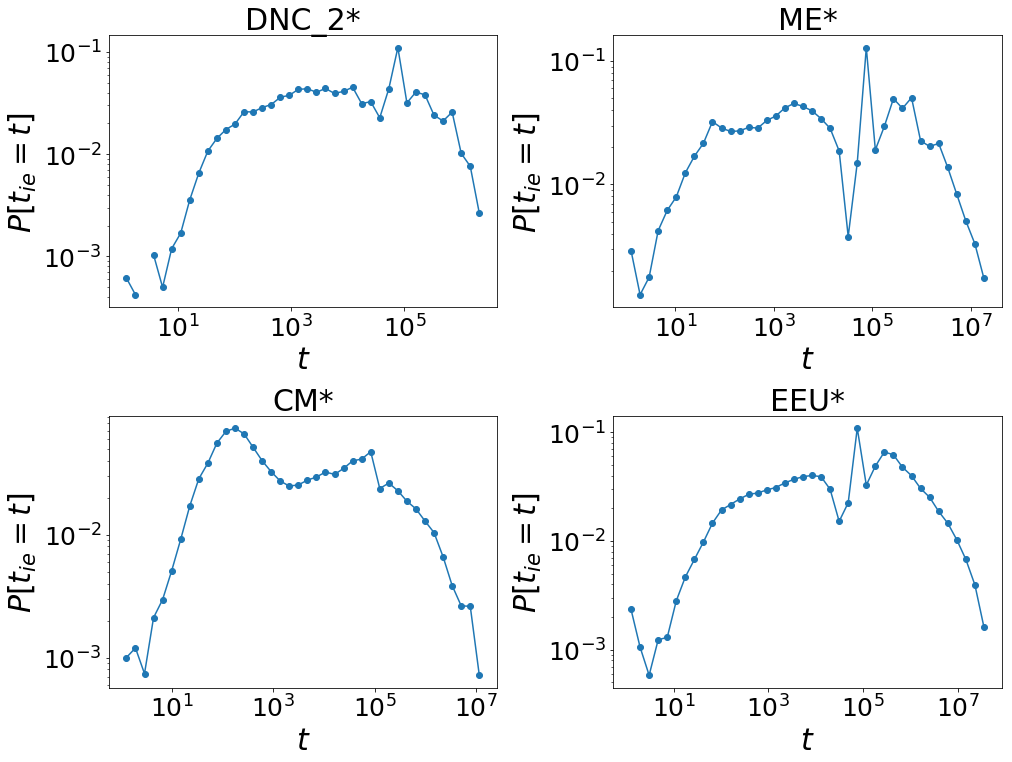

40
40
40
40
40
40
40
40
40
folder existing
degree existing


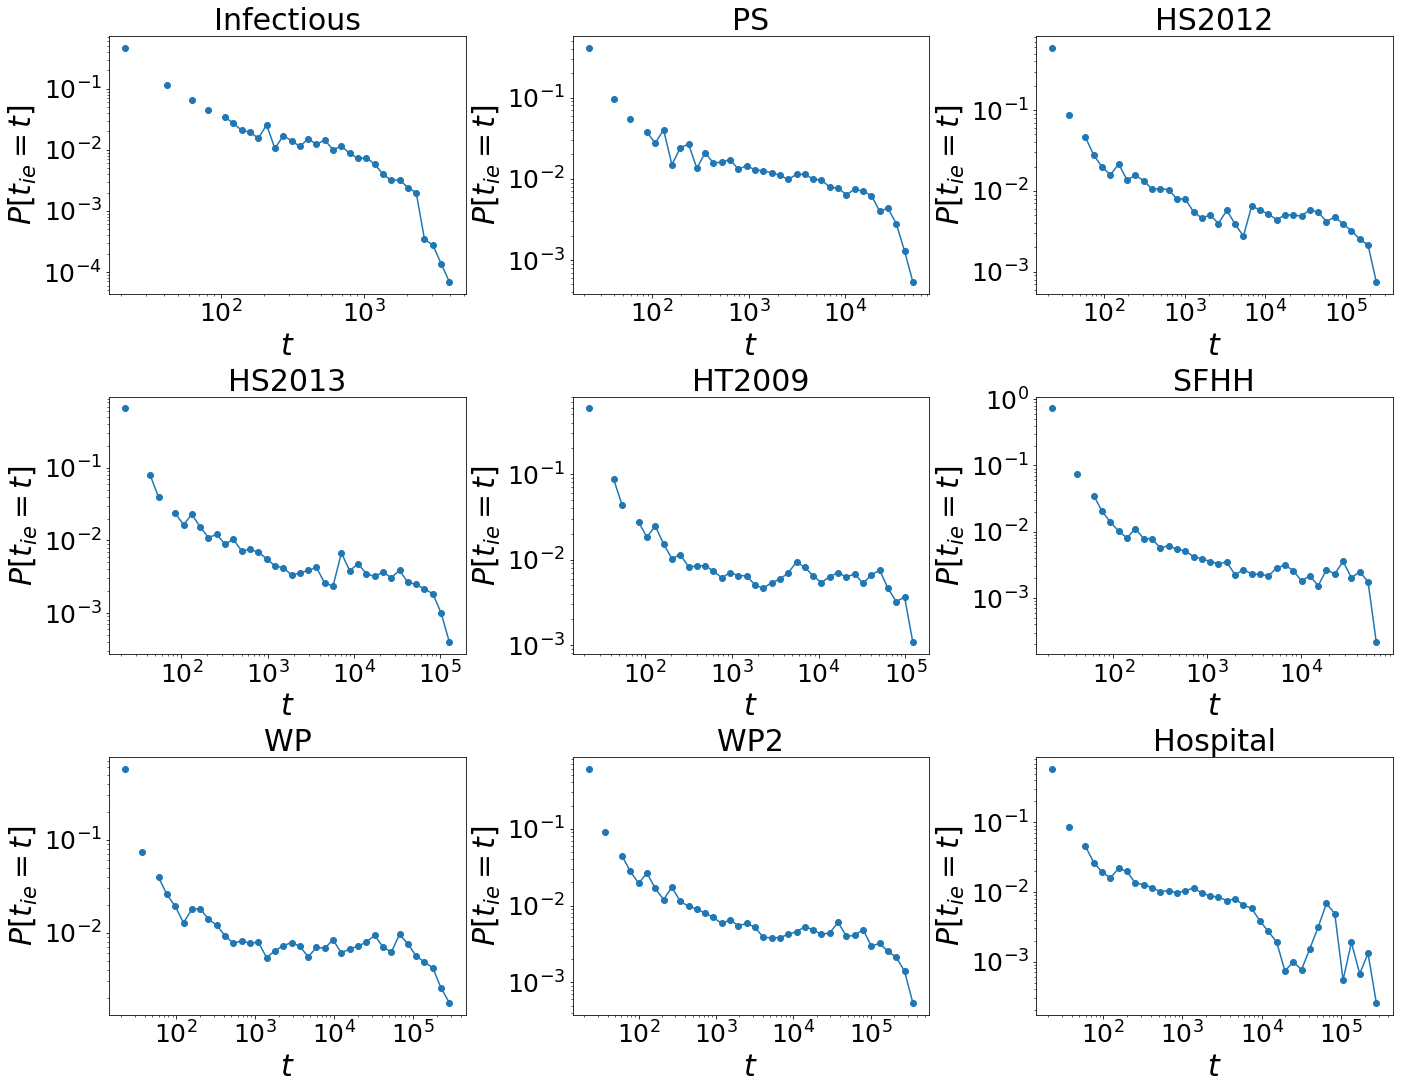

In [59]:
for t_list in [mail_list,human_contact_list]:
    i_et_distr(t_list, binned = True, save = True)